We made this copy to test for moving several new plots to  `figure_plot.py`.

In [1]:
import graph_create, voronoi_local, jaccard_similarity, figure_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import shapely 

from scipy.spatial import Voronoi

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [2]:
sample = 'PileaTLeaf2'
dot_folder= 'dot_images'
vein_folder= 'vein_graphs'

G = graph_create.graph_creation(sample, dot_folder, vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [3]:
# local tests:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,8.380696,6.707946,0.264142,0.223166


We use the centroid dots and random dots in the face as baselines for the local test.

In [4]:
# baseline local tests:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [5]:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

In [6]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])

-------
## Statistically compare dot-pair performance in all passed faces

In [7]:
# combine local test results:
rst_df = rst[1]
rst_df['type'] = 'hydathode'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])
df.reset_index(level=0, inplace=True)


In [8]:
df

,index,angle_diff,dist_diff,type
0,0,6.216283,1.291966,hydathode
1,1,21.154174,0.940535,hydathode
2,2,8.569301,0.354510,hydathode
3,3,0.134818,0.083914,hydathode
4,4,2.452549,0.290713,hydathode
...,...,...,...,...
719,176,31.927488,1.716054,random
720,177,8.672533,0.112914,random
721,178,14.721330,1.306477,random
722,179,3.779940,1.287985,random


In [9]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)

In [10]:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [11]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,8.380696,6.707946,0.264142,0.223166
centroid,10.125135,8.245539,0.331264,0.259851
midpoint,12.585426,9.609237,0.410281,0.314734
random,22.219653,17.785460,0.852067,0.573389


-------
## Function 1 to add:

In [12]:
def plot_testable(G, G_dual):

    'shade the testable polygons, can use after we perform the local test.'

    node_position_G = {}
        
    node_position_dual = {}


    for node in G.nodes:
        node_position_G[node] = node

    edge_style = ['solid' if G.edges[e]['shared'] =='tested_shared' else 'dashed' for e in G.edges]
    edge_col = ['black' if G.edges[e]['shared'] =='tested_shared' else 'C7' for e in G.edges]

    for node in G_dual.nodes:
        node_position_dual[node] = node

    fig, ax = plt.subplots(figsize=(10,10/G.graph['ratio']))

    for i in range(len(G.graph['faces_passed'])):
        p = mpl.patches.Polygon(G.graph['faces_passed'][i], facecolor = 'C7', alpha = .1)
        ax.add_patch(p)

    nx.draw_networkx_edges(G, pos=node_position_G, edge_color = edge_col, style = edge_style, ax = ax) 

    nx.draw(G_dual, pos=node_position_dual, node_size= 20,  node_color= 'seagreen', 
            edge_color ='seagreen',  width = 1, ax = ax)


    plt.show()   

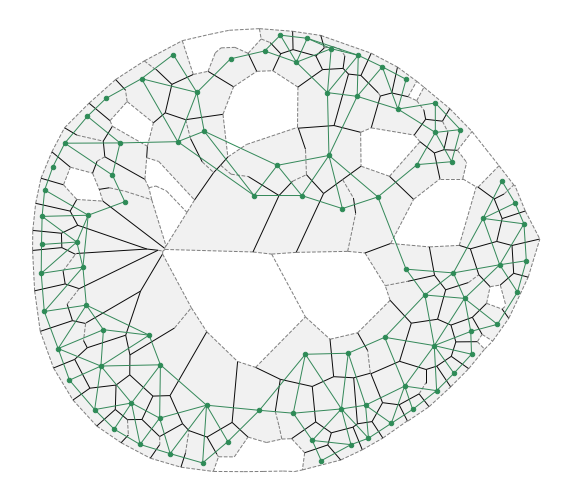

In [13]:
plot_testable(G, G_dual)

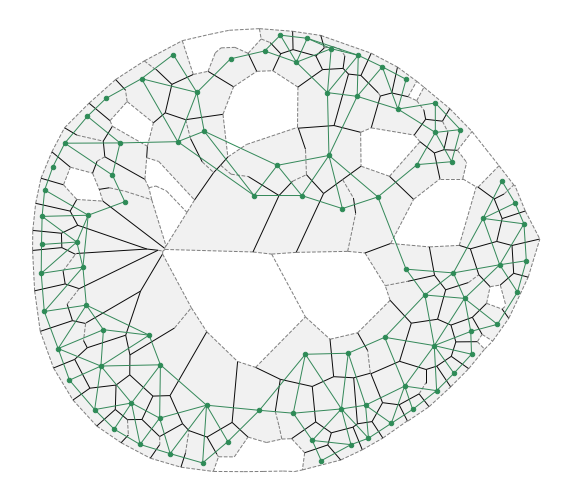

In [14]:
figure_plot.plot_testable(G, G_dual)

-------------

## Perform area test

In [15]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions, type = 'dot')

In [16]:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions, type = 'centroid')
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions, type = 'midpoint')
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions, type = 'random')

J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, columns = ['dots', 'centroid', 'midpoint', 'random'])

J_df.head()


,dots,centroid,midpoint,random
0,0.574379,0.712459,0.731789,0.446613
1,0.577096,0.592104,0.624394,0.499346
2,0.617267,0.570301,0.613601,0.230060
3,0.689141,0.762550,0.735559,0.352266
4,0.689476,0.744619,0.662318,0.443827


In [17]:
single_dot = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds]



## Function 2 to add (05/14): plot overlap diff

In [18]:
def plot_overlap_diff(G, bounded_regions, seeds, single_dot, type = 'dot'):
    fig, ax = plt.subplots(figsize = (8, 8/G.graph['ratio']))

    node_positions = {}

    for node in G.nodes:
        node_positions[node] = node

    dot_color = {'dot':'C1', 'centroid':'red','midpoint': 'hotpink', 'random':'purple'}
    color = dot_color[type]

    # plot veins:     
    nx.draw_networkx_edges(G, pos=node_positions, edge_color = 'C7', ax = ax, width = 1.5, alpha = .8) 

    # plot voronoi polygons:
    for i in range(len(bounded_regions)):
        ax.plot(np.array(bounded_regions[i])[:,0], np.array(bounded_regions[i])[:,1], alpha = .7, color = 'C7') # change color to grey

    # plot diff patches:
    for geom in G.graph[f'diff_geom_{type}']:  

        if isinstance(geom, shapely.geometry.polygon.Polygon):
            contour = list(geom.exterior.coords)
           
            if len(contour):
                p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                ax.add_patch(p)
                
            if len(list(geom.interiors)):
                interior = list(geom.interiors[0].coords)
                p_in = mpl.patches.Polygon(contour, facecolor = 'white', alpha = 1)
                ax.add_patch(p_in)
                
        else: # multipolygon.MultiPolygon
            for ploy in geom:
                contour = list(ploy.exterior.coords)
                if len(contour):
                    p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                    ax.add_patch(p)

                    
                if len(list(ploy.interiors)):
                    interior = list(ploy.interiors[0].coords)
                    p_in = mpl.patches.Polygon(interior, facecolor = 'white', alpha = 1)
                    ax.add_patch(p_in)
    
    # plot seeds:
    ax.scatter(np.array(seeds)[:,0], np.array(seeds)[:,1], s = 10, c = 'C7')

    for i in range(len(bounded_regions)):
        if single_dot[i]:
            ax.scatter(seeds[i][0], seeds[i][1], s = 10, c = dot_color[type])


    plt.show()
        

<ipython-input-18-64d315cbea96>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


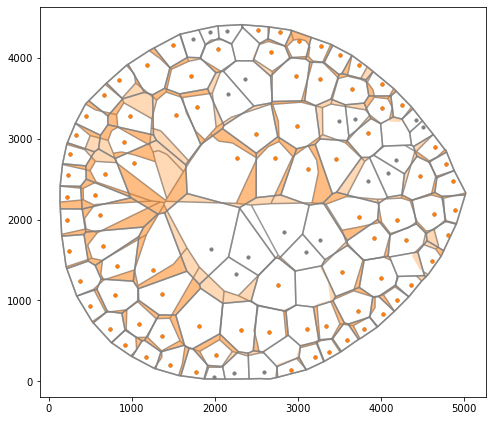

<ipython-input-18-64d315cbea96>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


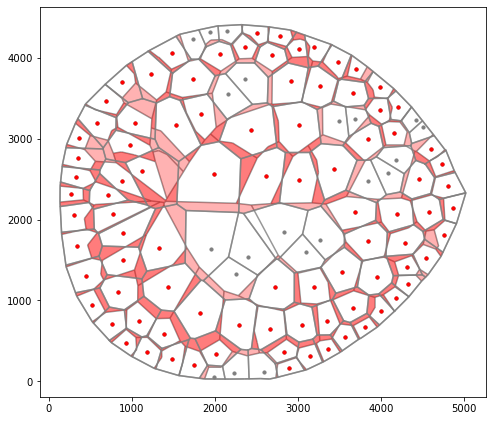

<ipython-input-18-64d315cbea96>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


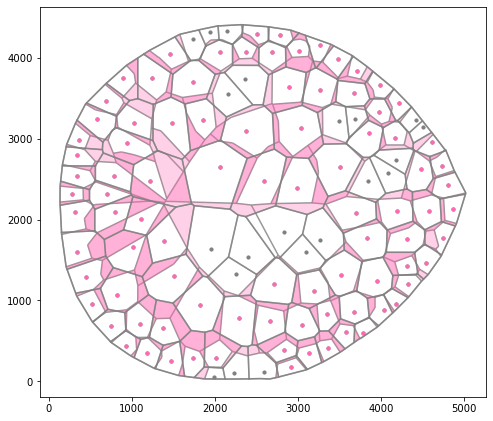

<ipython-input-18-64d315cbea96>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


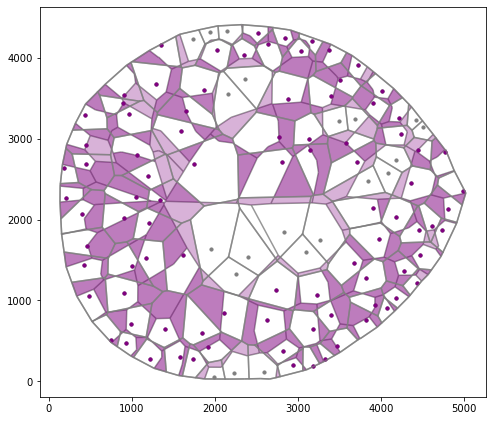

In [19]:
plot_overlap_diff(G, bounded_regions, seeds, single_dot, type = 'dot')
plot_overlap_diff(G, bounded_regions= centroid_bounded_regions, seeds = centroid_seeds, single_dot =  single_dot, type = 'centroid')
plot_overlap_diff(G, bounded_regions= midpoint_bounded_regions, seeds = midpoint_seeds, single_dot =  single_dot, type = 'midpoint')
plot_overlap_diff(G, bounded_regions = random_bounded_regions, seeds = random_seeds, single_dot =  single_dot, type = 'random')

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/figure_plot.py:348: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


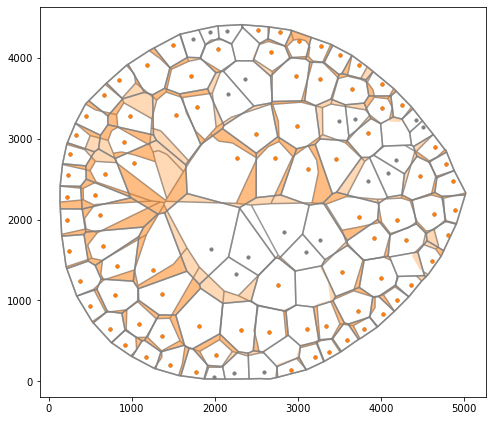

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/figure_plot.py:348: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


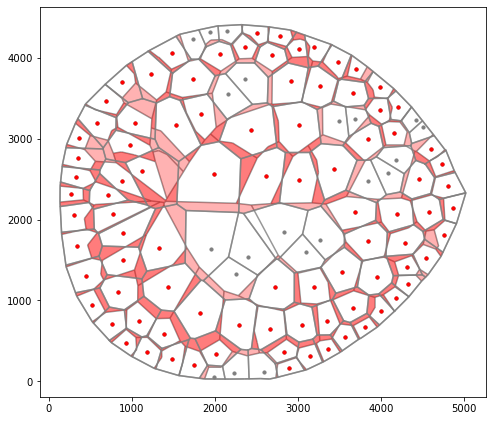

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/figure_plot.py:348: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


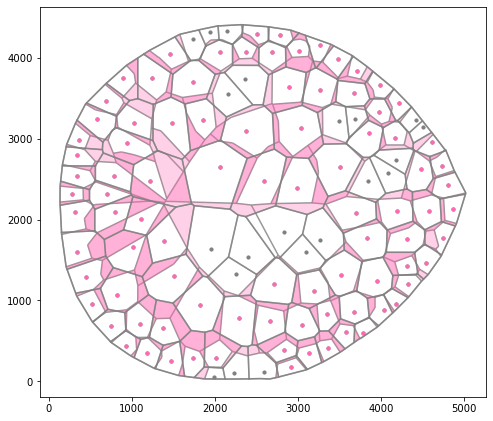

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/figure_plot.py:348: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


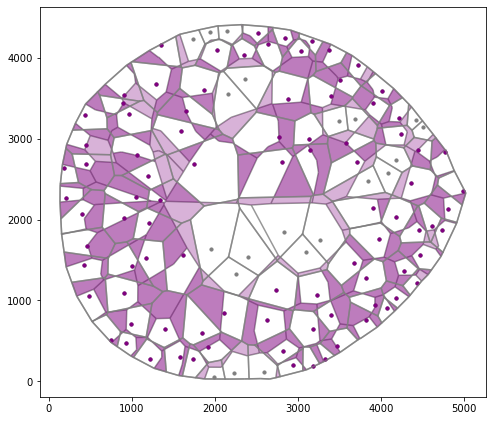

In [20]:
figure_plot.plot_overlap_diff(G, bounded_regions, seeds, single_dot, type = 'dot')
figure_plot.plot_overlap_diff(G, bounded_regions= centroid_bounded_regions, seeds = centroid_seeds, single_dot =  single_dot, type = 'centroid')
figure_plot.plot_overlap_diff(G, bounded_regions= midpoint_bounded_regions, seeds = midpoint_seeds, single_dot =  single_dot, type = 'midpoint')
figure_plot.plot_overlap_diff(G, bounded_regions = random_bounded_regions, seeds = random_seeds, single_dot =  single_dot, type = 'random')